In [1]:
# pull hrrr model data in zarr format from AWS S3
# example source: https://mesowest.utah.edu/html/hrrr/
# AWS S3 bucket: https://hrrrzarr.s3.amazonaws.com/index.html#sfc/
import xarray
import rioxarray as rxr
import rasterio as rio
import salem
import s3fs
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path): 
        return s3fs.S3Map(path, s3=s3) 

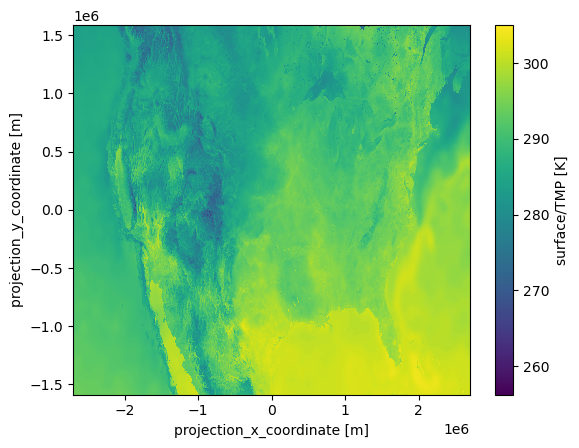

In [3]:
path = "hrrrzarr/sfc/20240603/20240603_12z_anl.zarr/surface/TMP" 
ds = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr", decode_coords="all") 
ds.TMP.plot()

In [4]:
ds

<xarray.Dataset> Size: 4MB
Dimensions:                  (projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(150, 150), meta=np.ndarray>
    forecast_period          timedelta64[ns] 8B ...
    forecast_reference_time  datetime64[ns] 8B ...
    height                   float64 8B ...
    pressure                 float64 8B ...
    time                     datetime64[ns] 8B ...

In [5]:
# assign the time variable to be a dimension.
ds2 = ds.expand_dims(time=[ds.time.data])
# convert x and y to lat and lon
# ds2 = ds2.rename({'x': 'lon', 'y': 'lat'})
# convert the projection to lat/lon
# ds3 = rxr.open_rasterio(ds2, variable='TMP', parse_coordinates=True)
# ds2 = ds2.rio.write_crs("epsg:4326")
# ds2.TMP.plot()

ds2



<xarray.Dataset> Size: 4MB
Dimensions:                  (time: 1, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2024-06-03T12:00:00
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 8B 00:00:00
    forecast_reference_time  (time) datetime64[ns] 8B 2024-06-03T12:00:00
    height                   (time) float64 8B 1e+03
    pressure                 (time) float64 8B 2.5e+04

In [9]:
ds3 = ds2.rio.write_crs("epsg:5070", inplace=True)
ds3



<xarray.Dataset> Size: 4MB
Dimensions:                  (time: 1, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2024-06-03T12:00:00
  * projection_x_coordinate  (projection_x_coordinate) float64 14kB -2.698e+0...
  * projection_y_coordinate  (projection_y_coordinate) float64 8kB -1.587e+06...
    spatial_ref              int64 8B 0
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 4MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 8B 00:00:00
    forecast_reference_time  (time) datetime64[ns] 8B 2024-06-03T12:00:00
    height                   (time) float64 8B 1e+03
    pressure                 (time) float64 8B 2.5e+04

In [10]:
# rename the x and y dimensions to lon and lat
ds3 = ds3.rename({'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
ds3

<xarray.Dataset> Size: 4MB
Dimensions:                  (time: 1, y: 1059, x: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2024-06-03T12:00:00
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
    spatial_ref              int64 8B 0
Data variables:
    TMP                      (time, y, x) float16 4MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 8B 00:00:00
    forecast_reference_time  (time) datetime64[ns] 8B 2024-06-03T12:00:00
    height                   (time) float64 8B 1e+03
    pressure                 (time) float64 8B 2.5e+04

In [12]:
# cast ds['TMP'] to a float32
ds3['TMP'] = ds3['TMP'].astype('float32')
ds3

<xarray.Dataset> Size: 8MB
Dimensions:                  (time: 1, y: 1059, x: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 8B 2024-06-03T12:00:00
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
    spatial_ref              int64 8B 0
Data variables:
    TMP                      (time, y, x) float32 8MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 8B 00:00:00
    forecast_reference_time  (time) datetime64[ns] 8B 2024-06-03T12:00:00
    height                   (time) float64 8B 1e+03
    pressure                 (time) float64 8B 2.5e+04

In [14]:
import pyproj
from rasterio.enums import Resampling
ds4 = ds3.rio.reproject("EPSG:3857", resampling=Resampling.bilinear)

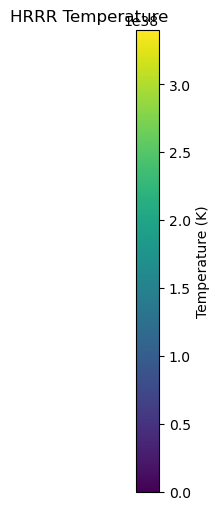

In [22]:
# plot ds4 as quadmesh with colorbar
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ds4.TMP.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
ax.coastlines()
plt.title('HRRR Temperature')
plt.show()


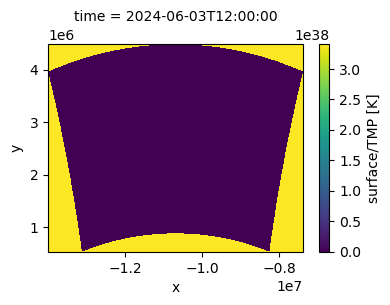

In [19]:
# ax = plt.axes(projection=ccrs.Mercator()) 
# ax.coastlines()
ds4.TMP.plot(x='x', y='y', col='time')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.animation as anim
import cartopy
import datetime

In [ ]:
# get 1 days worth of data starting today - 4 hours and lookback 6 hours. Convert from system clock to UTC.
endDate = datetime.datetime.now().astimezone(datetime.timezone.utc)
endDate = endDate - datetime.timedelta(hours=4)
lookbackHours = 6
startDate = endDate - datetime.timedelta(hours=lookbackHours)

# get the data "hrrrzarr/sfc/{%Y%m%d}/{%Y%m%d}_{hh}z_fcst.zarr/surface/TMP"
paths = []
for date in range(lookbackHours):
    date = startDate + datetime.timedelta(hours=date)
    path = f"hrrrzarr/sfc/{date:%Y%m%d}/{date:%Y%m%d}_{date:%H}z_anl.zarr/surface/TMP"
    paths.append(path)
paths

In [ ]:
# load the first dataset
ds1 = xarray.open_mfdataset([lookup(paths[0]), lookup(f"{paths[0]}/surface")], engine="zarr")
# make time a coordinate
ds1 = ds1.expand_dims(time=[ds1.time.data])
# merge the rest of the datasets
for path in paths[1:]:
    # get the time value
    print(path)
    ds2 = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr")
    ds2 = ds2.expand_dims(time=[ds2.time.data])
    ds1 = xarray.concat([ds1, ds2], dim="time")
ds1


In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# Set up levels etc in this call 
image = ds2.TMP.isel(time = 0).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), x='projection_x_coordinate', y='projection_y_coordinate', animated=True)